In [1]:
''' 1. 모듈 임포트 '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.5.0+cu101  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. CIFAR10 데이터 다운로드 '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

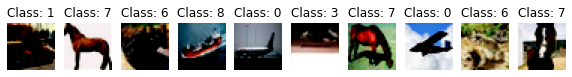

In [6]:
''' 4. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 5. PyTorch 내에서 제공하는 딥러닝 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()

In [ ]:
''' 6. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
''' 7. 불러온 Resnet34 학습, Test 성능 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))


In [9]:
def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [10]:
''' 8. Resnet34 학습 실행 '''
''' 9. EPOCH 별 Test set Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    valid_loss, valid_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.904041
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.550688
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.851851
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.497261
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.697571
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.497426
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.798281
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.225628

[EPOCH: 1], 	Validation Loss: 0.0425, 	Validation Accuracy: 52.45 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.158609
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.944690
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.312806
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.844205
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.075644
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.180691
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.361226
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.048399

[EPOCH: 2], 	Validation Loss: 0.0312, 	Valid

In [ ]:
''' 10. IMAGENET 데이터로 학습이 된 ResNet34 모델을 불러온 후 Fine Tuning 해보기 '''
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    valid_loss, valid_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.419555
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.207843
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.025392
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 0.889689
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.030636
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.713344
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.199397
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.778328

[EPOCH: 1], 	Validation Loss: 0.0593, 	Validation Accuracy: 66.74 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.273258
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.902417
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.862746
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.758329
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.957550
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.698427
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.744019
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.834088

[EPOCH: 2], 	Validation Loss: 0.0240, 	Valid